In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from numpy import asarray
from sklearn.model_selection import train_test_split
import csv
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import np_utils


from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [2]:
# read the image file names and corresponding labels
def read_labels(company_name):
    x = []
    y = []

    with open(f'data/{company_name}.csv', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            x.append(row[0])
            y.append(row[1])
    x = x[1:]
    y = [int(i) for i in y[1:]]

    x = np.array(x)
    y = np.array(y)

    return x, y

In [3]:
# convert images to array of pixels
def read_pixels(x):
  pixels = np.zeros(shape=(len(x), 100, 100, 4))

  for i in range(len(x)):
    image = Image.open('data/images/'+ x[i] + '.png', mode='r')#.convert('L')
    data = asarray(image)
    pixels[i] = data
  pixels = pixels / 255.0 # normalization

  return pixels

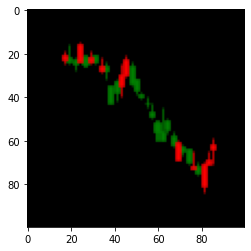

In [4]:
# check if images are loaded correctly
x = read_labels('AAPL')[0]
plt.imshow(read_pixels(x)[0])

In [5]:
def trainTestSplit(pixels, y, test_size = 0.2):
    # splitting the dataset into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(pixels, y, test_size=test_size, random_state=2) 
    # one-hot encoding
    Y_train = np_utils.to_categorical(Y_train, num_classes=2)
    Y_test = np_utils.to_categorical(Y_test, num_classes=2)
    
    return X_train, X_test, Y_train, Y_test

In [6]:
def model():
    #https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook
    model = Sequential()

    model.add(Conv2D(filters = 8, kernel_size = (3, 3),padding = 'same', activation ='relu', input_shape = (100, 100, 4)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', activation ='relu'))

    # fully connected
    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(2, activation = "softmax"))

    return model

In [7]:
def train(model, X_train, Y_train, X_test, Y_test, epochs=30, batch_size=512):
    model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])

    #fit the model
    history = model.fit(X_train,Y_train, batch_size=batch_size, epochs = epochs, validation_data = (X_test,Y_test), verbose=0)
    Y_pred = model.predict(X_test)
    return history, Y_pred

In [8]:
def plotTraining(mdl, history, X_test, Y_test):
    plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')

    test_loss, test_acc = mdl.evaluate(X_test,  Y_test, verbose=2)

In [9]:
def plotConfisionMatrix(Y_test, Y_pred):
    Y_test_cm = np.argmax(Y_test, axis = 1)
    Y_pred_cm = np.argmax(Y_pred, axis = 1)
    cm = confusion_matrix(Y_test_cm, Y_pred_cm, labels=[0, 1])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()
    return cm

In [10]:
def run(company_name):
    x, y = read_labels(company_name)
    pixels = read_pixels(x)
    X_train, X_test, Y_train, Y_test = trainTestSplit(pixels=pixels, y=y, test_size=0.3)
    mdl = model()
    history, Y_pred = train(model=mdl, batch_size=512,  epochs=30, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,)
    plotTraining(mdl, history, X_test, Y_test)
    plotConfisionMatrix(Y_test, Y_pred)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-12 16:06:48.215068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 16:06:48.215211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-12 16:06:48.811581: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-12 16:06:49.079649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-12 16:06:50.933808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/29 [=====>........................] - ETA: 0s

2022-10-12 16:07:34.199738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 36ms/step
29/29 - 1s - loss: 0.6934 - categorical_accuracy: 0.4918 - 767ms/epoch - 26ms/step


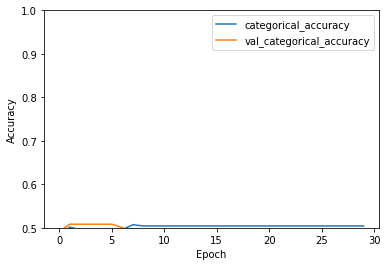

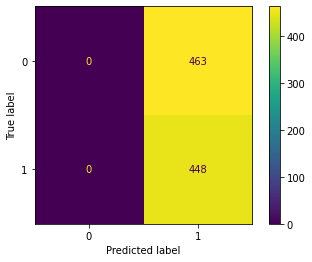

In [11]:
run('TSLA')